# Proyecto Final Maestria Ciencias de la Computación UNSA

**Curso:** Visión Artificial

**Proyecto:** Exploración de Vision **Transformer** para la clasificación de células normales de sangre periférica.

**Integrantes:**
* Abel Edmundo Borit Guitton
* Luis Alberto Borit Guitton
* Betzy Jacqueline Yarin Ramıirez

Arequipa, 2024

## Dataset

Descargar el dataset a utilizar desde https://data.mendeley.com/datasets/snkd93bnjr/1 y crear una carpeta en el drive llamada `Colab Notebooks` (la cual es la que se crea automáticamente al crear un nuevo proyecto de Notebook en Colab) y luego dentro crear una carpeta llamada `DatosProyecto` en la cual se colocorá el dataset descargado en .zip ya que más adelante se copiará ese dataset.zip en el proyecto de colab y se descomprimirá para utilizar sus datos.

## Librerias Requeridas

In [1]:
!pip install -Uqq fastbook timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00


In [2]:
import os
import re
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import timm
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

## Obtener datos del .Zip

In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Definir el directorio de los datos
DIR = "/content/gdrive/MyDrive/Colab Notebooks/DatosProyecto"

# Copiar y descomprir el archivo zip con los datos
start_time = time.time()
with zipfile.ZipFile(os.path.join(DIR, "PBC_dataset_normal_DIB.zip"), 'r') as zip_ref:
    zip_ref.extractall("/content")

print("*"*80)
print("Tiempo de ejecución para cargar y descomprimir los datos:", time.time() - start_time, "segundos")
print("*"*80)

Mounted at /content/gdrive
********************************************************************************
Tiempo de ejecución para cargar y descomprimir los datos: 10.423043727874756 segundos
********************************************************************************


## EDA

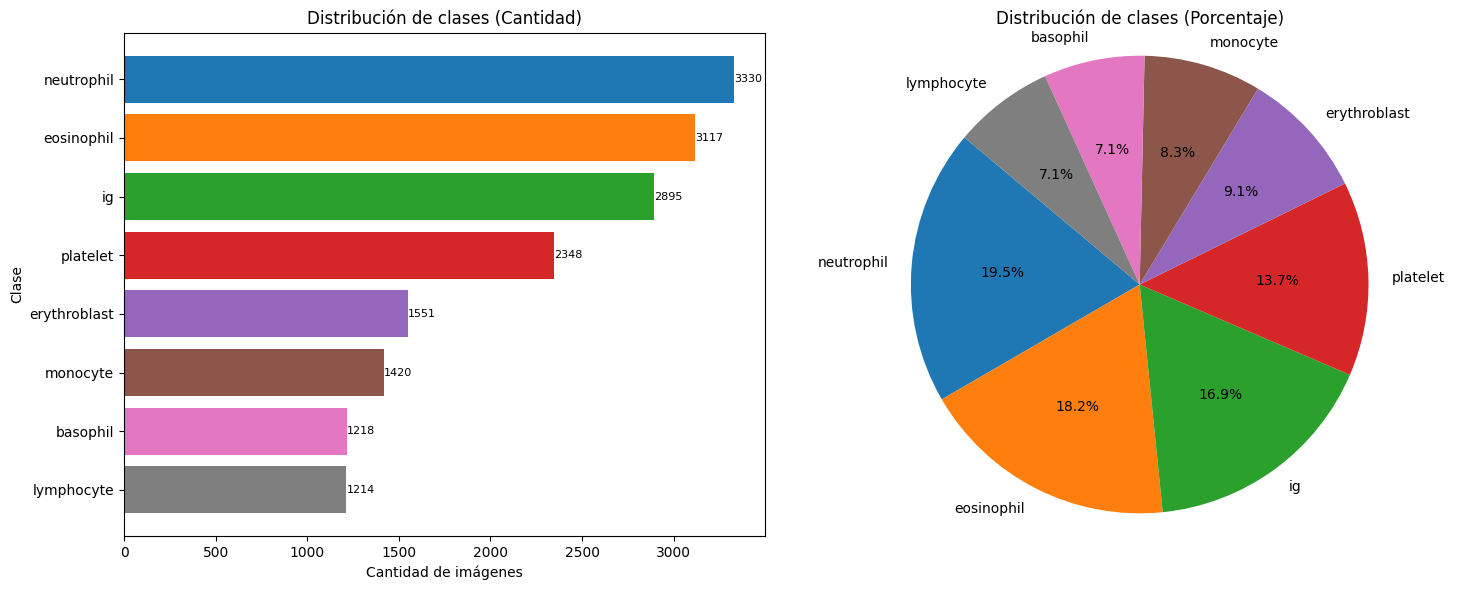

In [4]:
data_dir = "/content/PBC_dataset_normal_DIB"

classes = os.listdir(data_dir)

file_counts = {}
total_files = 0
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    file_counts[cls] = len(os.listdir(cls_dir))
    total_files += file_counts[cls]

sorted_classes = sorted(classes, key=lambda x: file_counts[x], reverse=True)

sorted_file_counts = [file_counts[cls] for cls in sorted_classes]
percentages = [(count / total_files) * 100 for count in sorted_file_counts]

colors = plt.cm.tab10.colors[:len(classes)]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
bars = plt.barh(sorted_classes, sorted_file_counts, color=colors)
plt.xlabel('Cantidad de imágenes')
plt.ylabel('Clase')
plt.title('Distribución de clases (Cantidad)')
plt.gca().invert_yaxis()

for bar, count in zip(bars, sorted_file_counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}',
             va='center', ha='left', fontsize=8)

plt.subplot(1, 2, 2)
plt.pie(percentages, labels=sorted_classes, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribución de clases (Porcentaje)')

plt.axis('equal')
plt.tight_layout()

plt.show()

## Entrenamiento del Modelo

In [5]:
def custom_transform(image):
    image = ImageOps.fit(image, (224, 224), method=0, bleed=0.0, centering=(0.5, 0.5))
    return image

# Transformaciones de datos
data_transforms = transforms.Compose([
    transforms.Resize((225, 225)),
    custom_transform,
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def custom_loader(path):
    try:
        return Image.open(path).convert('RGB')
    except Exception as e:
        print(f"Error al cargar la imagen {path}: {e}")
        return None

# Remover el archivo .DS_169665.jpg
path_ne = os.path.join("/content/PBC_dataset_normal_DIB/neutrophil")
os.remove(os.path.join(path_ne, ".DS_169665.jpg"))

# Dataset y dataloaders
dataset = ImageFolder("/content/PBC_dataset_normal_DIB", transform=data_transforms, loader=custom_loader)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Modelo ViT
model = timm.create_model("vit_base_patch16_224_in21k", pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = 8
num_inputs = model.head.in_features
last_layer = nn.Linear(num_inputs, num_classes)
model.head = last_layer

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("*"*80)
print("Se está ejecutando con GPU" if torch.cuda.is_available() else "Se está ejecutando con CPU")
print("*"*80)
model.to(device)

num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        try:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        except Exception as e:
            print(f"Error: {e}")

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print("*"*80)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

    # Validación
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
        val_kappa = cohen_kappa_score(true_labels, predictions)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Balanced Accuracy: {val_balanced_accuracy:.4f}")
        print(f"Validation Cohen's Kappa: {val_kappa:.4f}")
        print("*"*80)

print("Tiempo de ejecución total:", time.time() - start_time, "segundos")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restar

model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

********************************************************************************
Se está ejecutando con GPU
********************************************************************************


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [1/20], Train Loss: 0.4417
Validation Loss: 0.2527
Validation Accuracy: 0.9193
Validation Balanced Accuracy: 0.9064
Validation Cohen's Kappa: 0.9054
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [2/20], Train Loss: 0.1832
Validation Loss: 0.1780
Validation Accuracy: 0.9450
Validation Balanced Accuracy: 0.9390
Validation Cohen's Kappa: 0.9356
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [3/20], Train Loss: 0.1409
Validation Loss: 0.1401
Validation Accuracy: 0.9561
Validation Balanced Accuracy: 0.9504
Validation Cohen's Kappa: 0.9486
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [4/20], Train Loss: 0.1217
Validation Loss: 0.1212
Validation Accuracy: 0.9640
Validation Balanced Accuracy: 0.9615
Validation Cohen's Kappa: 0.9579
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [5/20], Train Loss: 0.1132
Validation Loss: 0.1460
Validation Accuracy: 0.9529
Validation Balanced Accuracy: 0.9419
Validation Cohen's Kappa: 0.9448
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [6/20], Train Loss: 0.1034
Validation Loss: 0.1162
Validation Accuracy: 0.9652
Validation Balanced Accuracy: 0.9626
Validation Cohen's Kappa: 0.9593
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [7/20], Train Loss: 0.0963
Validation Loss: 0.1315
Validation Accuracy: 0.9599
Validation Balanced Accuracy: 0.9639
Validation Cohen's Kappa: 0.9532
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [8/20], Train Loss: 0.0912
Validation Loss: 0.1280
Validation Accuracy: 0.9611
Validation Balanced Accuracy: 0.9552
Validation Cohen's Kappa: 0.9545
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [9/20], Train Loss: 0.0818
Validation Loss: 0.1026
Validation Accuracy: 0.9687
Validation Balanced Accuracy: 0.9670
Validation Cohen's Kappa: 0.9634
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [10/20], Train Loss: 0.0817
Validation Loss: 0.1181
Validation Accuracy: 0.9634
Validation Balanced Accuracy: 0.9643
Validation Cohen's Kappa: 0.9572
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [11/20], Train Loss: 0.0773
Validation Loss: 0.1212
Validation Accuracy: 0.9620
Validation Balanced Accuracy: 0.9531
Validation Cohen's Kappa: 0.9554
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [12/20], Train Loss: 0.0741
Validation Loss: 0.1330
Validation Accuracy: 0.9629
Validation Balanced Accuracy: 0.9606
Validation Cohen's Kappa: 0.9565
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [13/20], Train Loss: 0.0741
Validation Loss: 0.1168
Validation Accuracy: 0.9681
Validation Balanced Accuracy: 0.9716
Validation Cohen's Kappa: 0.9627
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [14/20], Train Loss: 0.0722
Validation Loss: 0.1102
Validation Accuracy: 0.9696
Validation Balanced Accuracy: 0.9689
Validation Cohen's Kappa: 0.9644
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [15/20], Train Loss: 0.0608
Validation Loss: 0.1135
Validation Accuracy: 0.9675
Validation Balanced Accuracy: 0.9674
Validation Cohen's Kappa: 0.9620
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [16/20], Train Loss: 0.0690
Validation Loss: 0.1449
Validation Accuracy: 0.9509
Validation Balanced Accuracy: 0.9470
Validation Cohen's Kappa: 0.9425
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [17/20], Train Loss: 0.0653
Validation Loss: 0.1184
Validation Accuracy: 0.9643
Validation Balanced Accuracy: 0.9549
Validation Cohen's Kappa: 0.9582
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [18/20], Train Loss: 0.0595
Validation Loss: 0.1273
Validation Accuracy: 0.9643
Validation Balanced Accuracy: 0.9571
Validation Cohen's Kappa: 0.9582
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [19/20], Train Loss: 0.0639
Validation Loss: 0.1124
Validation Accuracy: 0.9672
Validation Balanced Accuracy: 0.9679
Validation Cohen's Kappa: 0.9616
********************************************************************************


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


********************************************************************************
Epoch [20/20], Train Loss: 0.0558
Validation Loss: 0.1159
Validation Accuracy: 0.9699
Validation Balanced Accuracy: 0.9658
Validation Cohen's Kappa: 0.9647
********************************************************************************
Tiempo de ejecución total: 4104.680584192276 segundos


## Graficos del Modelo

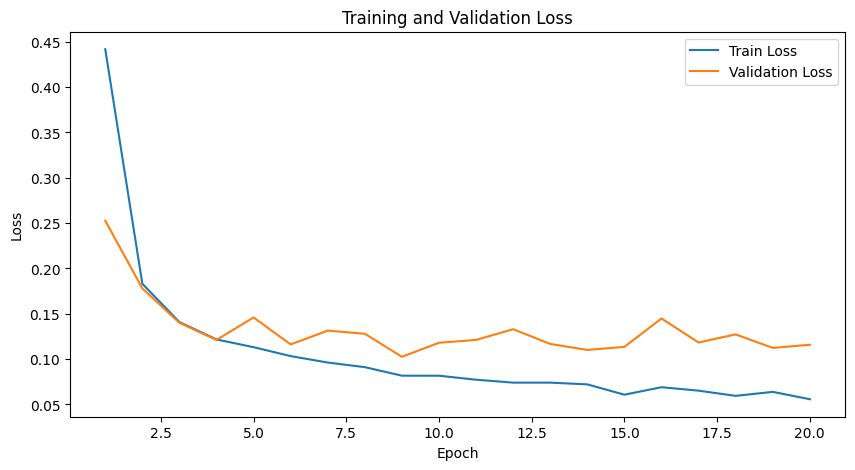

<Figure size 1400x1200 with 0 Axes>

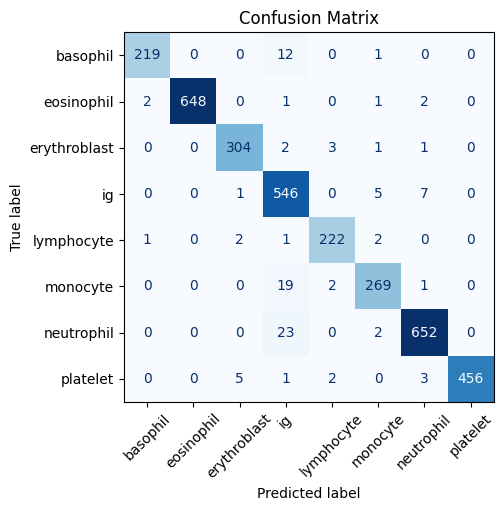

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


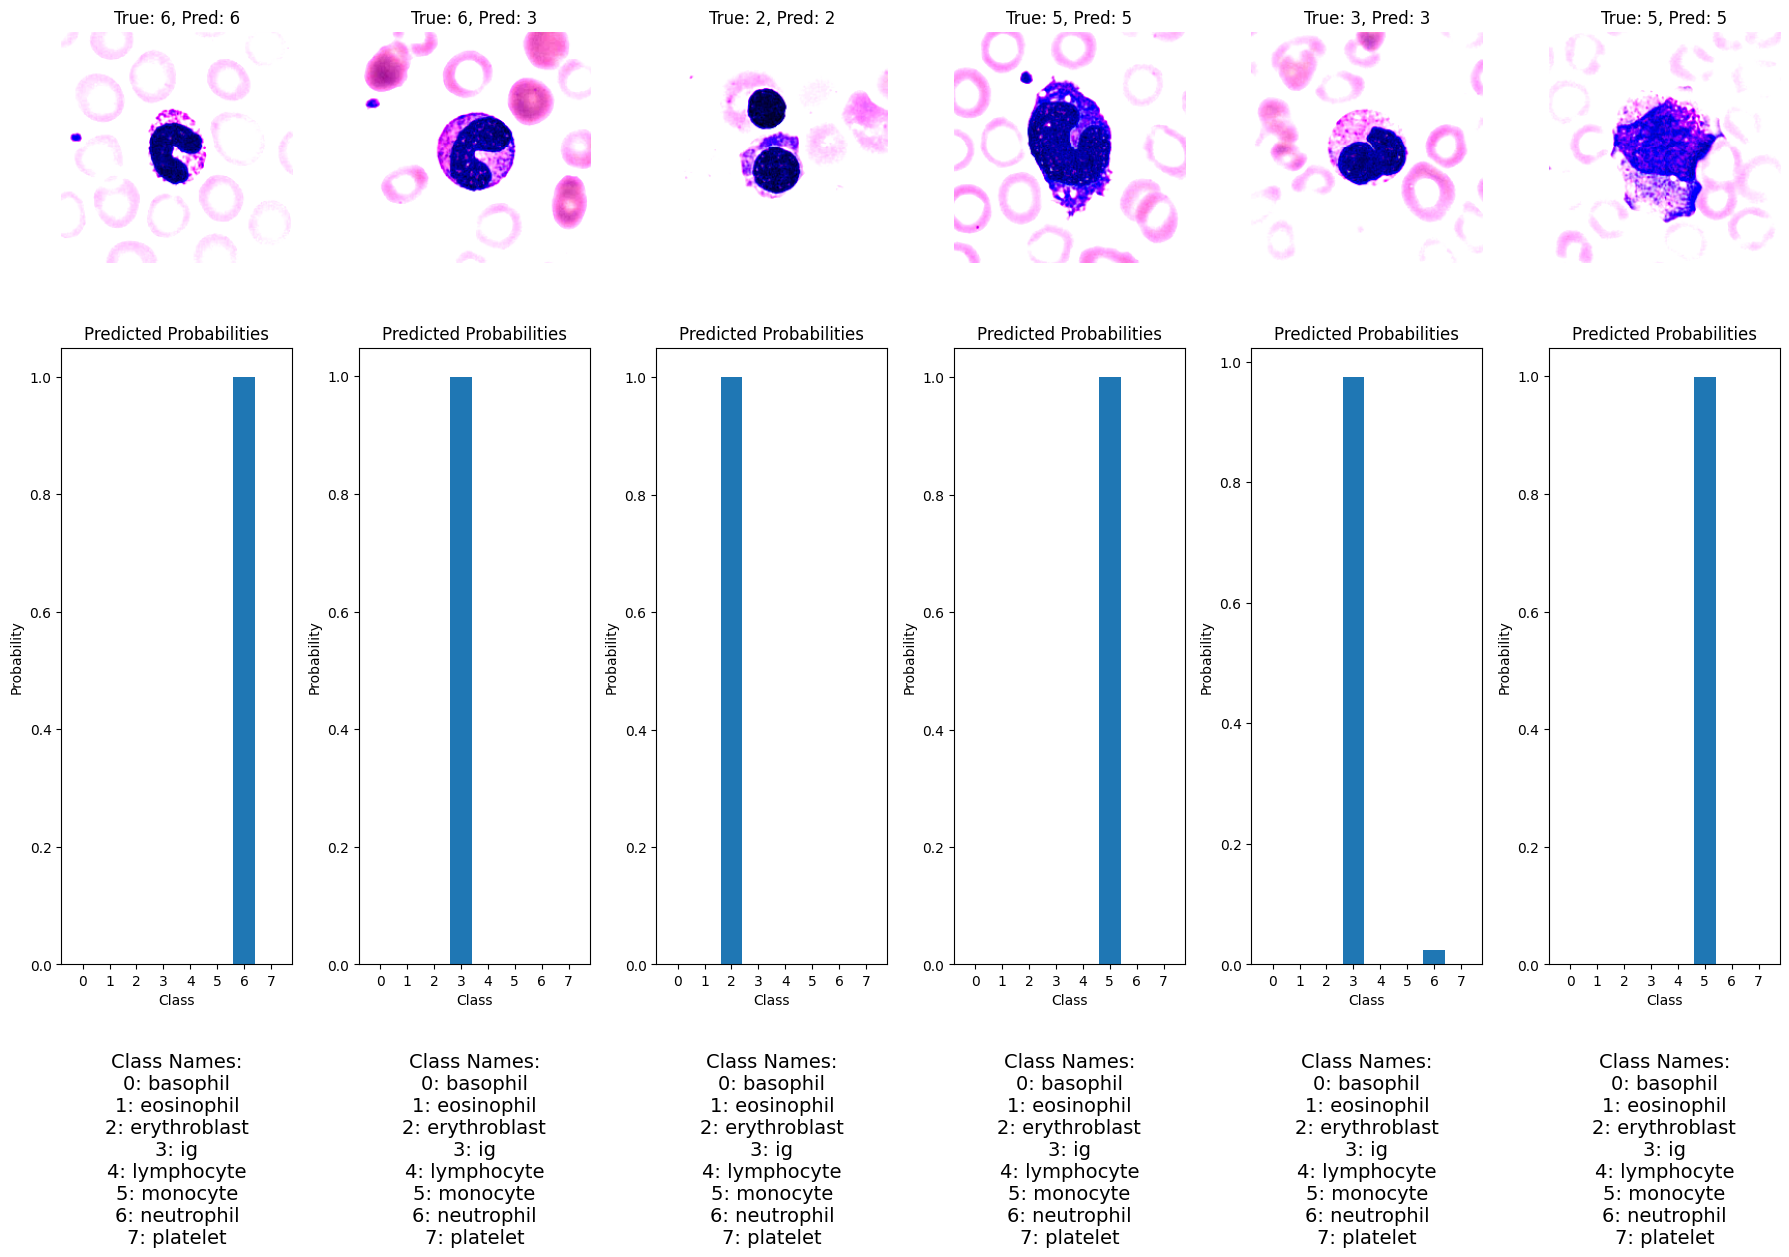

In [6]:
# Gráficas
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Obtener los nombres de las clases (según nombres de carpetas)
class_names = [folder_name.split("_")[0] for folder_name in dataset.classes]

# Matriz de confusión
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(14, 12))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title('Confusion Matrix')
plt.show()

# Obtener predicciones y etiquetas en el conjunto de validación
model.eval()
val_predictions = []
val_true_labels = []
val_probabilities = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())
        val_probabilities.extend(probabilities.cpu().numpy())

# Mostrar resultados
num_samples = 6 # controlar la cantidad de muestras visualizadas
plt.figure(figsize=(18, 14))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(val_dataset[i][0].permute(1, 2, 0))
    plt.title(f"True: {val_true_labels[i]}, Pred: {val_predictions[i]}")
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(range(8), val_probabilities[i])
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Probabilities')
    plt.xticks(range(8))

    # Añadir leyenda
    legend_text = '\n'.join([f'{j}: {class_names[j]}' for j in range(8)])
    plt.text(0.5, -0.3, f'Class Names:\n{legend_text}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.show()

##  Predecir todos los archivos imagenes del Content Colab

## Generación del Pickle

In [9]:
import pickle

# Guardar el modelo entrenado en un archivo pickle
torch.save(model.state_dict(), 'trained_model.pth')

# Crear un diccionario con la información necesaria para la inferencia
model_info = {
    'class_names': dataset.classes,
    'transform': data_transforms
}

# Guardar el diccionario en un archivo pickle
with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

## Ejecución del Pickle



************************************************************
                 Se está ejecutando con GPU                 
************************************************************




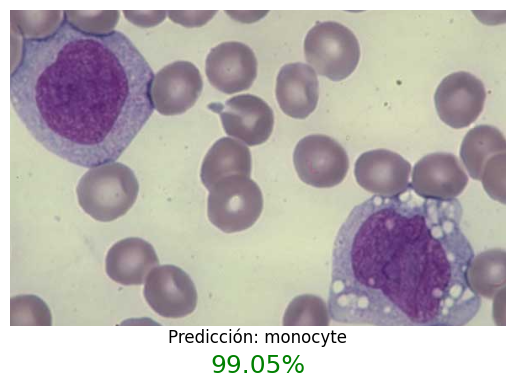

In [91]:
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch.nn as nn

# Verificar si hay una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n")
print("*" * 60)
print("{:^60}".format("Se está ejecutando con GPU" if torch.cuda.is_available() else "Se está ejecutando con CPU"))
print("*" * 60)
print("\n")

# Cargar el diccionario del archivo pickle
with open('model_info.pkl', 'rb') as f:
    model_info = pickle.load(f)

# Cargar el modelo entrenado
model = timm.create_model("vit_base_patch16_224_in21k", pretrained=False)
num_classes = 8
num_inputs = model.head.in_features
last_layer = nn.Linear(num_inputs, num_classes)
model.head = last_layer
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Transformaciones de datos para la imagen de entrada
data_transforms = model_info['transform']

# Función para realizar la inferencia con una imagen nueva
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Añadir dimensión del batch
    with torch.no_grad():
        output = model(image_tensor)
    probabilities = torch.softmax(output, dim=1)
    predicted_prob, predicted_idx = torch.max(probabilities, 1)
    class_names = model_info['class_names']
    predicted_class = class_names[predicted_idx.item()]

    prob_percent = predicted_prob.item() * 100

    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')

    # Determinar el color del texto de la probabilidad
    if prob_percent < 33:
        prob_color = 'red'
    elif prob_percent < 66:
        prob_color = 'yellow'
    else:
        prob_color = 'green'

    # Agregar texto con el resultado debajo de la imagen
    plt.text(0.5, -0.12, 'Predicción: {}\n'.format(predicted_class), fontsize=12, ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.15, '{:.2f}%'.format(prob_percent), fontsize=18, ha='center', color=prob_color, transform=plt.gca().transAxes)

    plt.show()

    return predicted_class

# Ruta de la imagen de entrada
image_path = "/content/monocyte8.png"

# Realizar la inferencia
predicted_class = predict_image(image_path, model, data_transforms)